In [0]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

from google.colab import drive
drive.mount('/content/drive')

np.random.seed(1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class MLP(nn.Module):
  def __init__(self, n_units, init_scale=1.0):
    super(MLP, self).__init__()

    self._n_units = copy.copy(n_units)
    self._layers = []
    for i in range(1, len(n_units)):
      layer = nn.Linear(n_units[i-1], n_units[i], bias=False)
      variance = math.sqrt(2.0 / (n_units[i-1] + n_units[i]))
      layer.weight.data.normal_(0.0, init_scale * variance)
      self._layers.append(layer)

      name = 'fc%d' % i
      if i == len(n_units) - 1:
        name = 'fc'  # the prediction layer is just called fc
      self.add_module(name, layer)


  def forward(self, x):
    x = x.view(-1, self._n_units[0])
    out = self._layers[0](x)
    for layer in self._layers[1:]:
      out = F.relu(out)
      out = layer(out)
    return out

In [0]:
cd drive/'My Drive'

/content/drive/My Drive


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr  6 03:04:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize])


train_dataset = datasets.CIFAR10(root='data', 
                                train=True, 
                                transform=transform_train,
                                download=True)

probability_of_random = 1.0

labels = np.array(train_dataset.targets)
mask = np.random.rand(len(labels)) <= probability_of_random
rnd_labels = np.random.choice(10, mask.sum())
labels[mask] = rnd_labels
labels = [int(x) for x in labels]

old_labels = train_dataset.targets

train_dataset.targets = labels


test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transform_test,
                                download=True)




train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=128,
                          num_workers=4,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=128,
                         num_workers=4,
                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Check that the labels were randomized

In [0]:
print(old_labels)

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 3, 9, 0, 7, 9, 7, 7, 9, 1, 5, 1, 6, 6, 8, 7, 1, 3, 0, 

In [0]:
print(train_dataset.targets)

[0, 1, 2, 5, 5, 2, 1, 0, 0, 6, 9, 2, 1, 6, 8, 5, 0, 2, 4, 5, 4, 8, 3, 7, 1, 1, 7, 5, 1, 6, 3, 1, 7, 2, 6, 9, 4, 9, 7, 3, 5, 1, 8, 7, 6, 5, 5, 2, 3, 7, 8, 3, 4, 7, 6, 2, 8, 3, 1, 7, 8, 4, 0, 5, 0, 7, 3, 2, 1, 3, 0, 5, 7, 8, 4, 9, 9, 8, 6, 5, 8, 3, 1, 2, 9, 0, 4, 7, 6, 5, 9, 0, 0, 5, 4, 6, 0, 2, 5, 3, 6, 5, 1, 5, 8, 3, 3, 4, 0, 1, 6, 7, 7, 1, 5, 3, 3, 4, 9, 4, 6, 2, 3, 2, 7, 4, 0, 2, 3, 9, 2, 8, 1, 0, 1, 6, 9, 1, 5, 1, 4, 1, 2, 3, 4, 0, 1, 9, 0, 9, 9, 0, 3, 7, 3, 6, 6, 6, 0, 5, 1, 0, 7, 6, 5, 7, 0, 0, 5, 6, 7, 6, 8, 9, 1, 0, 1, 5, 0, 0, 1, 1, 2, 8, 1, 1, 2, 8, 2, 0, 9, 2, 6, 2, 1, 3, 4, 9, 2, 7, 9, 8, 7, 0, 4, 1, 5, 7, 7, 8, 8, 6, 8, 8, 4, 9, 4, 0, 5, 4, 5, 7, 5, 5, 5, 8, 9, 4, 6, 6, 0, 8, 9, 7, 2, 7, 9, 4, 5, 7, 0, 1, 7, 7, 3, 1, 2, 9, 1, 1, 2, 6, 7, 3, 5, 1, 8, 6, 0, 7, 5, 8, 6, 5, 4, 1, 7, 4, 8, 5, 4, 8, 3, 0, 7, 6, 6, 3, 9, 2, 3, 0, 4, 2, 4, 8, 9, 4, 6, 7, 3, 5, 7, 3, 0, 3, 4, 4, 8, 2, 4, 1, 5, 5, 0, 4, 7, 1, 1, 8, 3, 4, 5, 1, 0, 2, 0, 5, 8, 4, 0, 1, 0, 2, 2, 6, 0, 9, 7, 8, 4, 0, 9, 

In [0]:
count = [1 for x in range(len(old_labels)) if old_labels[x] == train_dataset.targets[x]]

In [0]:
sum(count)
#10% are the same, due to random chance

4873

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


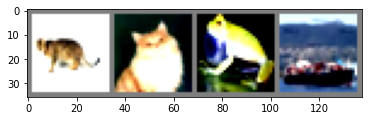

plane   dog   cat horse


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
mlp_spec = '512'
n_units = [int(x) for x in mlp_spec.split('x')] # hidden dims
n_units.append(10)  # output dim
n_units.insert(0, 32*32*3)        # input dim
model = MLP(n_units)

optimizer = torch.optim.SGD(model.parameters(), .01, momentum=0.9, weight_decay=0)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50, 100, 150], gamma=0.1, last_epoch=-1)

In [0]:
def compute_acc(model, data_loader):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
        probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [0]:
criterion = nn.CrossEntropyLoss()

cost_list = []
train_acc_list = []


epoch_max = 200

for epoch in range(epoch_max):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
    # compute output
      output = model(features)
      loss = criterion(output, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      cost_list.append(loss.item())
      if not batch_idx % 150:
        print (f'Epoch: {epoch+1:03d}/{epoch_max:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {loss:.4f}')
    if epoch % 10 == 0:
          torch.save(model.state_dict(), 'MLP_randomlabels_randomseed1')
    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader)        
        print(f'Epoch: {epoch+1:03d}/{epoch_max:03d}\n'
              f'Train ACC: {train_acc:.2f}')
        
        train_acc_list.append(train_acc)
        if np.isclose(train_acc, 0.0):
          torch.save(model.state_dict(), 'MLP_randomlabels_randomseed1')
    scheduler.step()

np.save('cost_MLP_randomlabels_randomseed1', cost_list)
np.save('trainacc_MLP_randomlabels_randomseed1', train_acc_list)

 

Epoch: 001/200 | Batch 000/391 | Cost: 3.0843
Epoch: 001/200 | Batch 150/391 | Cost: 2.4607
Epoch: 001/200 | Batch 300/391 | Cost: 2.3717
Epoch: 001/200
Train ACC: 13.79
Epoch: 002/200 | Batch 000/391 | Cost: 2.3205
Epoch: 002/200 | Batch 150/391 | Cost: 2.3483
Epoch: 002/200 | Batch 300/391 | Cost: 2.2490
Epoch: 002/200
Train ACC: 15.30
Epoch: 003/200 | Batch 000/391 | Cost: 2.2493
Epoch: 003/200 | Batch 150/391 | Cost: 2.2960
Epoch: 003/200 | Batch 300/391 | Cost: 2.2778
Epoch: 003/200
Train ACC: 17.18
Epoch: 004/200 | Batch 000/391 | Cost: 2.2274
Epoch: 004/200 | Batch 150/391 | Cost: 2.2129
Epoch: 004/200 | Batch 300/391 | Cost: 2.3121
Epoch: 004/200
Train ACC: 18.94
Epoch: 005/200 | Batch 000/391 | Cost: 2.2269
Epoch: 005/200 | Batch 150/391 | Cost: 2.1832
Epoch: 005/200 | Batch 300/391 | Cost: 2.2652
Epoch: 005/200
Train ACC: 20.05
Epoch: 006/200 | Batch 000/391 | Cost: 2.2179
Epoch: 006/200 | Batch 150/391 | Cost: 2.2674
Epoch: 006/200 | Batch 300/391 | Cost: 2.2333
Epoch: 006/2

KeyboardInterrupt: ignored

In [0]:
model.load_state_dict(torch.load('MLP_randomlabels_randomseed1'))

<All keys matched successfully>

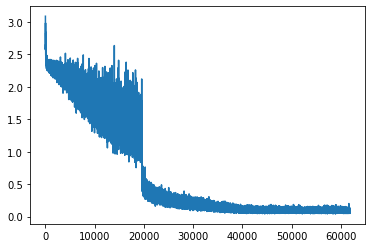

In [0]:
plt.plot(cost_list)

In [0]:
 with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader)        
        print(f'train ACC: {train_acc:.2f}')

train ACC: 99.25


In [0]:
 with torch.set_grad_enabled(False): # save memory during inference
        
        test_acc = compute_acc(model, test_loader)        
        print(f'Test ACC: {test_acc:.2f}')

Test ACC: 10.06


In [0]:
model

MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=False)
  (fc): Linear(in_features=512, out_features=10, bias=False)
)

In [0]:
!pip install weightwatcher

  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp36-none-any.whl size=24787 sha256=696df444ef5e4f12cdb19e6d6a9c2a19aba97b974115244bd1f3fdf04279fbf4
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


2020-04-06 04:08:24,010 INFO 

python      version 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
numpy       version 1.18.2
tensforflow version 2.2.0-rc2
keras       version 2.2.5
2020-04-06 04:08:24,012 INFO Analyzing model
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


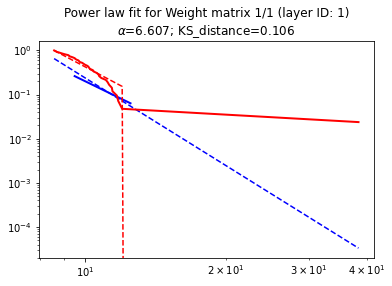

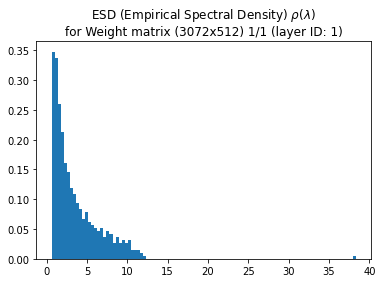

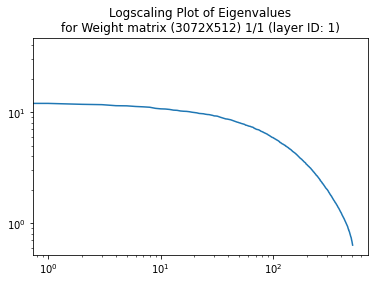

/usr/local/lib/python3.6/dist-packages/weightwatcher/RMT_Util.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1/(2*np.pi*sigma*sigma*x*y))*np.sqrt((b-x)*(x-a))
/usr/local/lib/python3.6/dist-packages/weightwatcher/RMT_Util.py:48: RuntimeWarning: invalid value encountered in sqrt
  return x, (1/(2*np.pi*sigma*sigma*x*y))*np.sqrt((b-x)*(x-a))


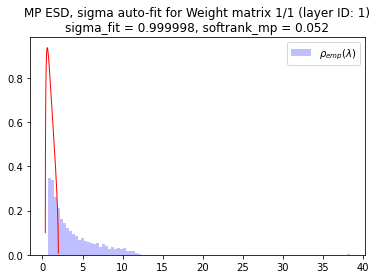

2020-04-06 04:08:28,280 INFO ### Printing results ###
2020-04-06 04:08:28,385 INFO Check: min: 0.04838945299690011, max: 0.17493394098600248, avg: 0.1116616969914513
2020-04-06 04:08:28,386 INFO Check compound: min: 0.04838945299690011, max: 0.17493394098600248, avg: 0.1116616969914513
2020-04-06 04:08:28,390 INFO CheckTF: min: False, max: False, avg: 0.0
2020-04-06 04:08:28,391 INFO CheckTF compound: min: 0.0, max: 0.0, avg: 0.0
2020-04-06 04:08:28,392 INFO Norm: min: 42.912254333496094, max: 42.912254333496094, avg: 42.912254333496094
2020-04-06 04:08:28,394 INFO Norm compound: min: 42.912254333496094, max: 42.912254333496094, avg: 42.912254333496094
2020-04-06 04:08:28,395 INFO LogNorm: min: 1.632581353187561, max: 1.632581353187561, avg: 1.632581353187561
2020-04-06 04:08:28,396 INFO LogNorm compound: min: 1.632581353187561, max: 1.632581353187561, avg: 1.632581353187561
2020-04-06 04:08:28,397 INFO Norm X: min: 108.24835205078125, max: 108.24835205078125, avg: 108.24835205078125
2

{'alpha': 6.607247559316917,
 'alpha_compound': 6.607247559316917,
 'alpha_weighted': 10.463604570012144,
 'alpha_weighted_compound': 10.463604570012144,
 'check': 0.1116616969914513,
 'checkTF': 0.0,
 'checkTF_compound': 0.0,
 'check_compound': 0.1116616969914513,
 'lognorm': 1.6325814,
 'lognormX': 2.0344212,
 'lognormX_compound': 2.0344212,
 'lognorm_compound': 1.6325814,
 'logpnorm': 10.466990647590144,
 'logpnorm_compound': 10.466990647590144,
 'logspectralnorm': 1.2831299,
 'logspectralnorm_compound': 1.2831299,
 'norm': 42.912254,
 'normX': 108.24835,
 'normX_compound': 108.24835,
 'norm_compound': 42.912254,
 'numofSpikes': 305.0,
 'numofSpikes_compound': 305.0,
 'ratio_numofSpikes': 0.5968688845401174,
 'ratio_numofSpikes_compound': 0.5968688845401174,
 'sigma_mp': 0.9999975585937502,
 'sigma_mp_compound': 0.9999975585937502,
 'softrank_mp': 0.05172502285979236,
 'softrank_mp_compound': 0.05172502285979236,
 'spectralnorm': 23.973831,
 'spectralnorm_compound': 23.973831}

In [0]:
import weightwatcher as ww
watcher = ww.WeightWatcher(model=model)
results = watcher.analyze(plot=True, alphas=True, mp_fit=True, spectralnorms=True)

watcher.get_summary()